In [1]:
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from numpy.random import default_rng

from corpus_proc import generate_dictionary, generate_dataset, WordDictionary
from stochasticity import Stochasticity, SegmentLabelDataset

from random import shuffle

## Data preprocessing

We use a cleaned version of the gutenberg poetry corpus provided by <name />. The data is formatted line by line into a json format, from we generate (1) a dictionary mapping words onto all possible POS tags and stress patterns they can have and (2) a model-ready dataset containing every stress sequence, segment durations, and segment labels.

Code to process is found in `corpus_proc.py`. Data is stored in and saved to a `corpus/` directory.

In [2]:
corpus_path = "corpus/josh-poet.txt"
corpus_fp = open(corpus_path)
corpus = [line for line in corpus_fp]
corpus_fp.close()

In [3]:
# generate db of words, their possible pos, and their stress patterns
generate_dictionary(corpus, 1000000, "corpus/josh_dict.db")

In [ ]:
# generate csv of stress sequences and labels
generate_dataset(corpus, 1000000, "corpus/josh_stress.csv")

## Model & Training

This is a simple encoder + recurrent neural network model. Decoding is done stochastically to randomise outputs.

In [3]:
# this can take a while to generate, but it will.
stress_dataset = SegmentLabelDataset("corpus/josh_stress.csv")

In [141]:
# dataloader
batch_size = 128

def collate_fn(batch):
    segments, labels = zip(*batch)
    return list(segments), torch.nn.utils.rnn.pad_sequence(labels, batch_first=True)

dataloader = DataLoader(stress_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)

In [7]:
model = Stochasticity(64)

In [ ]:
# model trainer code
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

model.train()
iterate = 0
loops = 0
losses = []
all_losses = []

for batch in dataloader:
    seq, labels = batch

    logits = model(seq, labels=labels, mode='train')
    loss = F.cross_entropy(logits.view(-1, 17), labels.view(-1))

    losses.append(loss.item())
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    iterate += 1
    if iterate % 100 == 0:
        loops += 1
        mean_loss = sum(losses) / 100
        print(mean_loss)
        all_losses.extend(losses)
        losses = []

    if loops >= 19:
        break

# graph cos i feel like it
plt.plot(all_losses, 'o-b')
plt.ylabel("loss")
plt.show()

epoch 0 loss: 0.467703805815789
epoch 1 loss: 0.4660834189384214
epoch 2 loss: 0.4578705035871075
epoch 3 loss: 0.45368843020931365
epoch 4 loss: 0.4489496206083605
epoch 5 loss: 0.44545883901657596
epoch 6 loss: 0.4429586010594522
epoch 7 loss: 0.4380718219664789
epoch 8 loss: 0.43782104503723884
epoch 9 loss: 0.4330179085654597
epoch 10 loss: 0.4301224879680141
epoch 11 loss: 0.4306955779752424
epoch 12 loss: 0.42463497769448066
epoch 13 loss: 0.42310468323769107
epoch 14 loss: 0.4162683458097519
epoch 15 loss: 0.4164304387184881
epoch 16 loss: 0.416440321553138
epoch 17 loss: 0.4128644937469113
epoch 18 loss: 0.4061514735221863
epoch 19 loss: 0.41149491936929766


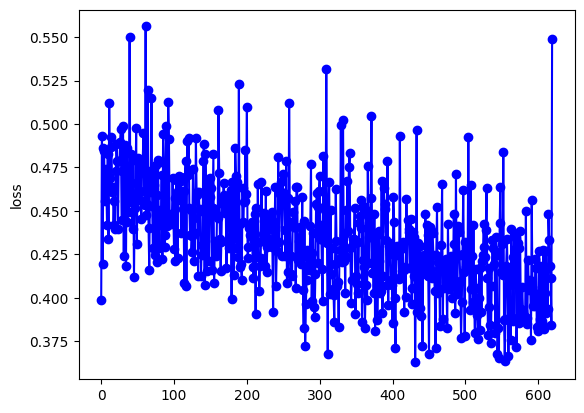

In [142]:
# model trainer code
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

model.train()
losses = []

for epoch in range(20):
    epoch_loss = []
    for batch in dataloader:
        seq, labels = batch

        logits = model(seq, labels=labels, mode='train')
        loss = F.cross_entropy(logits.view(-1, 17), labels.view(-1))

        losses.append(loss.item())
        epoch_loss.append(loss.item())
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    epoch_loss = sum(epoch_loss) / len(dataloader)
    print(f"epoch {epoch} loss: {epoch_loss}")

# graph cos i feel like it
plt.plot(losses, 'o-b')
plt.ylabel("loss")
plt.show()

## Evaluation

Just a simple test example, with the library deocder attached to the end.

In [4]:
model = torch.load("models/boo.pt", weights_only=False)

In [143]:
model.eval()

Stochasticity(
  (encoder): SegmentEncoder(
    (embedding): Embedding(3, 16)
    (bilstm): LSTM(16, 32, batch_first=True, bidirectional=True)
  )
  (decoder): POSDecoder(
    (label_emb): Embedding(18, 32)
    (gru): GRU(96, 64, batch_first=True)
    (out): Linear(in_features=64, out_features=17, bias=True)
  )
)

In [6]:
dictionary = WordDictionary("corpus/josh_dict.db")
print(stress_dataset.vocab.id2label)

['DET', 'PROPN', 'CCONJ', 'SCONJ', 'PRON', 'NOUN', 'AUX', 'ADP', 'VERB', 'ADJ', 'ADV', 'PART', 'NUM', 'INTJ', 'X']


In [7]:
def seq_splitter(seq, success=0.8):
    geny = default_rng()

    start_index = 0
    split = []

    while start_index < len(seq):
        if start_index + 1 == len(seq):
            split.append(torch.Tensor(seq[start_index:]).type(torch.int32)) 
            start_index += 1
        
        subseq_len = geny.geometric(success)

        if subseq_len + start_index > len(seq):
            continue

        else:
            split.append(torch.Tensor(seq[start_index:start_index + subseq_len]).type(torch.int32))
            start_index += subseq_len
    
    return [split]

In [203]:
test_seq = seq_splitter([0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1])
print(test_seq)
preds = model(test_seq, mode="decode")
print(preds)
sentence = []
#or pred in preds:
for count in range(len(test_seq[0])):
    words = dictionary.get_words_from(stress_dataset.vocab.id2label[preds[0][count]], "".join([str(val) for val in test_seq[0][count].tolist()]))
    shuffle(words)
    sentence.append(words[0][0])
print(" ".join(sentence))
sentence = []

[[tensor([0], dtype=torch.int32), tensor([1], dtype=torch.int32), tensor([0], dtype=torch.int32), tensor([1], dtype=torch.int32), tensor([0, 1], dtype=torch.int32), tensor([0, 1], dtype=torch.int32), tensor([0, 1], dtype=torch.int32), tensor([0], dtype=torch.int32), tensor([1, 0], dtype=torch.int32), tensor([1], dtype=torch.int32)]]
tensor([[7, 5, 0, 5, 7, 4, 9, 2, 5, 5]])
with dark a mast around ourselves chinese and pointers ghost


In [ ]:
# run to kill db connection
dictionary.close()

In [173]:
# save good models
torch.save(model, "models/tres.pt")

## Testing Model Wrapper Code

Testing the code to generate stanzas at a time.

In [25]:
from generator import PoetryGenerator, COMMON_METER
gen = PoetryGenerator("models/tres.pt", "corpus/josh_stress.csv", "corpus/josh_dict.db")

In [38]:
stanzas = []

for i in range(100):
    stanzas.append(gen.gen_common_metre(temperature=0.5, seed=i))

for stanza in stanzas:
    for line in stanza:
        print(line)
    print("")

and pay with these essay behind
or couples for response
be those alone good from years whence
a save between this tock

not satisfiable

not satisfiable

not satisfiable

not satisfiable

atop correct or sliced for no
the search with names than some
and echo by that drop around
or overhead years as

not satisfiable

not satisfiable

and overhead this place unlike
along a year that save
perhaps that doodle for the firm
was light than they will his

beneath this cat that shame believed
about that scorching might
or duct her boot to problem off
that billions at a sum

about a fires hope in which
or what be these its feels
and wallet up that scream to ebb
except yourself reprieve

that wares to draw a flurry joke
a novels towards that rule
towards chinese attempt and arts
abstract and most aloft

and waters in that price with void
beyond enough event
behind a weight beside are found
a lyrics live with wit

between untold compute or ring
aloft a rate between
the lightning than the none was 